# SMS spam collection dataset: Naive Bayes algorithm
The following exercise is taken from <b> Machine Learning with R</b> by <b> Brett Lantz </b> (Third Edition)

The dataset used in the exercise is the <b>SMS Spam Collection</b> dataset and originates from <b> UCI Machine Learning Repository</b>. Initially, the dataset was developed by <b>Gómez, Almeida and Yamakami (2012)</b>. The dataset here is downloaded from the textbook's github page.

## Step 1: Collecting data

In [1]:
sms_raw <- read.csv("https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-with-R-Third-Edition/master/Chapter04/sms_spam.csv",
                   stringsAsFactors = F)

## Step 2: Exploring and preparing the data

In [2]:
str(sms_raw)

'data.frame':	5559 obs. of  2 variables:
 $ type: chr  "ham" "ham" "ham" "spam" ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or Â£10,000 cash needs your URGENT collection. 09066364349 NOW from Landline"| __truncated__ ...


In [4]:
# The SMS type has erroneously been classfied as character, therefore it must be converted to a factor
sms_raw$type <- factor(sms_raw$type)
table(sms_raw$type)


 ham spam 
4812  747 

### Data preparation - cleaning and standardizing test data

In [8]:
library(tm)
sms_corpus <- VCorpus(VectorSource(sms_raw$text))
print(sms_corpus)
inspect(sms_corpus[1:2])
as.character(sms_corpus[[1]])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5559
<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 49

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 23



[1] "Hope you are having a good week. Just checking in"

In [17]:
# Transforming strings to lower case characters
sms_corpus_clean <- tm_map(sms_corpus, content_transformer(tolower))
as.character(sms_corpus_clean[[1]])

[1] "hope you are having a good week. just checking in"

In [18]:
# Remove numbers from strings
sms_corpus_clean <- tm_map(sms_corpus_clean, removeNumbers)
# Remove stop words
sms_corpus_clean <- tm_map(sms_corpus_clean, removeWords, stopwords())
# elimintating punctuation
sms_corpus_clean <- tm_map(sms_corpus_clean, removePunctuation)

library(SnowballC)
# Stemming words
sms_corpus_clean <- tm_map(sms_corpus_clean, stemDocument)
# Remove blank spaces
sms_corpus_clean <- tm_map(sms_corpus_clean, stripWhitespace)

In [19]:
as.character(sms_corpus[[1]])
as.character(sms_corpus_clean[[1]])

[1] "Hope you are having a good week. Just checking in"

[1] "hope good week just check"

### Data preparation - splitting text documents into words

In [21]:
sms_dtm <- DocumentTermMatrix(sms_corpus_clean)

# Theoretically, the whole cleaning process could have been performed at this stage in one step:
sms_dtm2 <- DocumentTermMatrix(sms_corpus, control = list(
                                                          to_lower = TRUE,
                                                          removeNumbers = TRUE,
                                                          stopwords = TRUE,
                                                          removePunctuation = TRUE,
                                                          stemming = TRUE))
# However, the order in the preprocessing matters, therefore, there are slight differences between the two methods. 
sms_dtm
sms_dtm2

<<DocumentTermMatrix (documents: 5559, terms: 6559)>>
Non-/sparse entries: 42146/36419335
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5559, terms: 6949)>>
Non-/sparse entries: 43204/38586287
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

### Data preparation - creating training and test datasets

In [22]:
0.75*5559

[1] 4169.25

In [25]:
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test <- sms_dtm[4170:5559, ]

# Create labels
sms_train_labels <- sms_raw[1:4169, ]$type
sms_test_labels <- sms_raw[4170:5559, ]$type

# Confirm that the subsets are representative
prop.table(table(sms_train_labels))
prop.table(table(sms_test_labels))

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

sms_test_labels
      ham      spam 
0.8683453 0.1316547 

### Visualizing text data - word clouds

Warning message:
"package 'wordcloud' was built under R version 3.6.2"
Loading required package: RColorBrewer



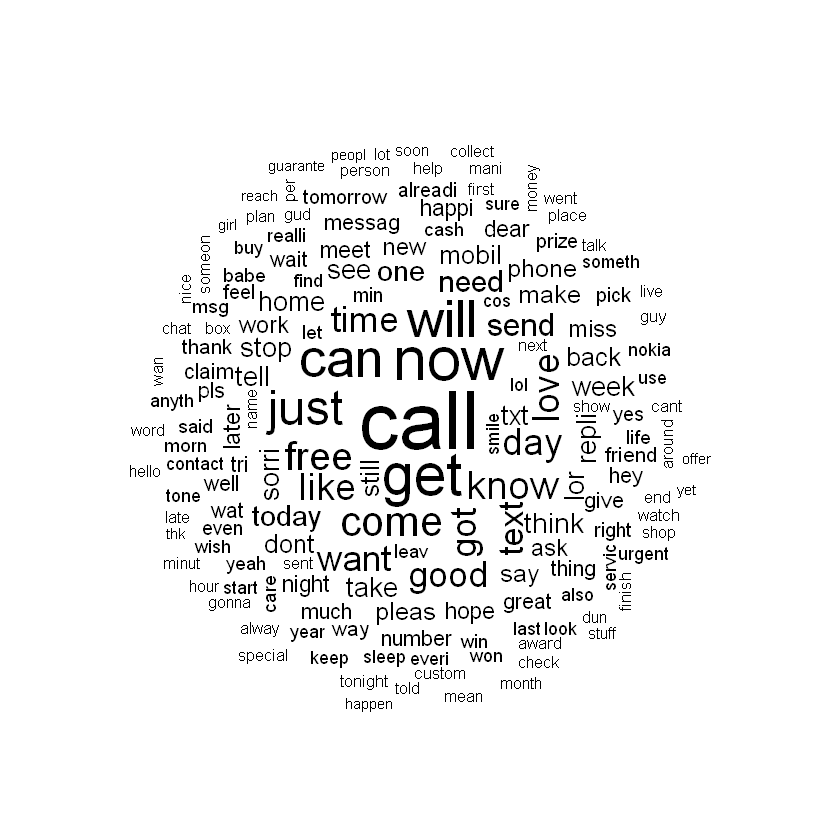

In [29]:
# Visualize corpus with a word cloud
library(wordcloud)
wordcloud(sms_corpus_clean, min.freq = 50, random.order = F)

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"


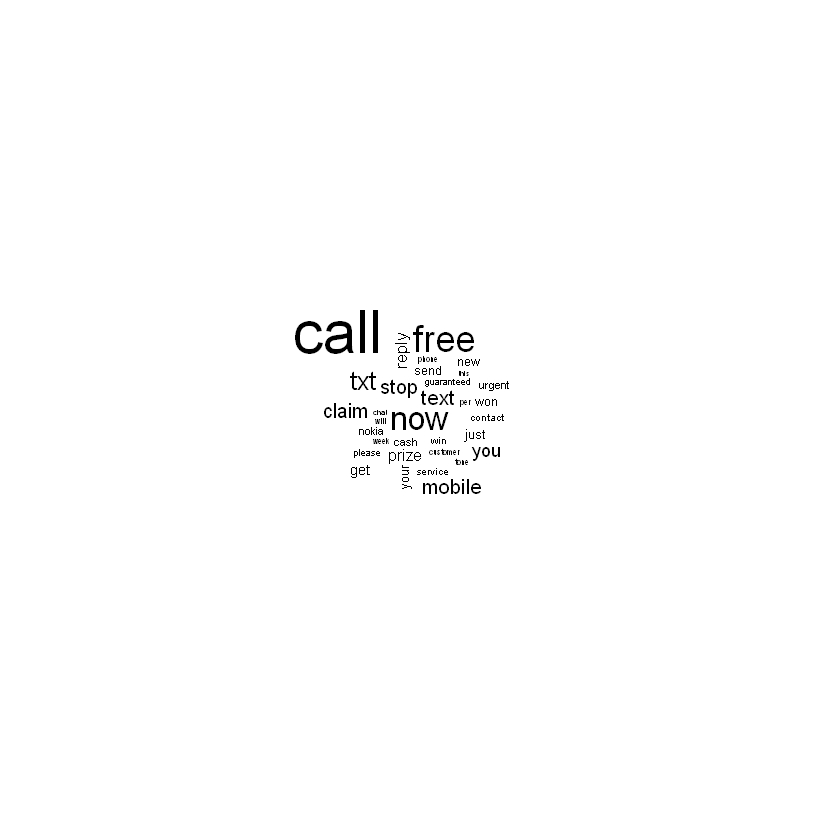

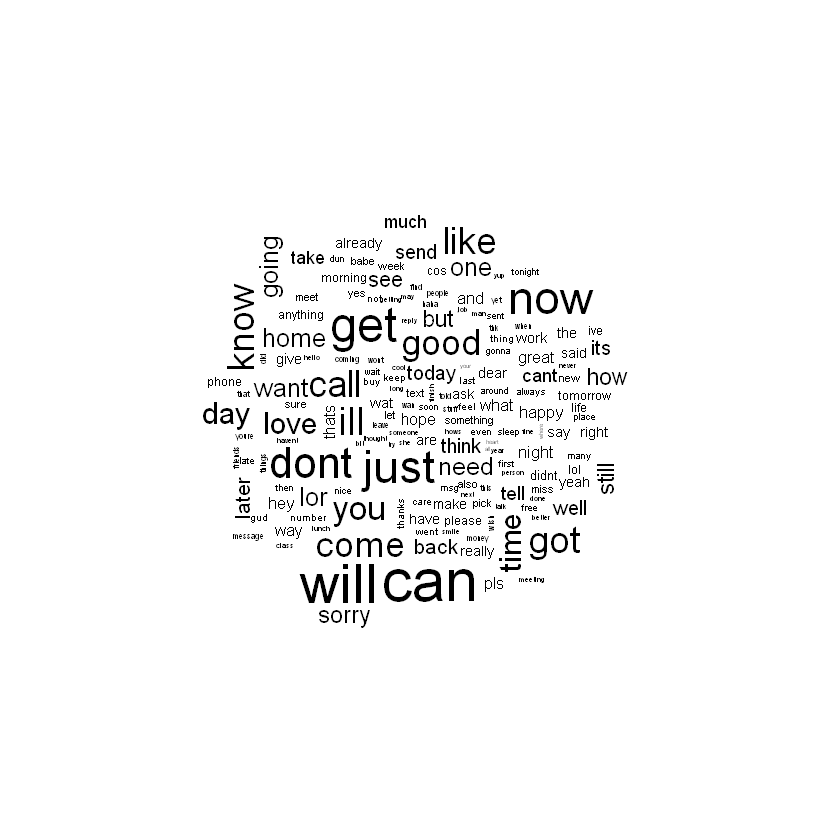

In [33]:
# Subset into spam and ham, then visualize
spam <- subset(sms_raw, type == "spam")
ham <- subset(sms_raw, type == "ham")

wordcloud(spam$text, min.freq = 40, scale = c(3, 0,7))
wordcloud(ham$text, min.freq = 40, scale = c(3, 0,7))

### Data preparation - creating indicator features for frequent words

In [34]:
# Eliminating all words appearing less than 5 times
sms_freq_words <- findFreqTerms(sms_dtm_train, 5)
str(sms_freq_words)

 chr [1:1138] "â£wk" "â\200“" "abiola" "abl" "abt" "accept" "access" ...


In [38]:
# filter training and test DTMs for frequent words vector
sms_dtm_freq_train <- sms_dtm_train[, sms_freq_words]
sms_dtm_freq_test <- sms_dtm_test[, sms_freq_words]

# Convert numerical variable into a categorical variable
convert_counts <- function(x) {
    x <- ifelse(x > 0, "Yes", "No")
}

sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)
sms_test <- apply(sms_dtm_freq_test, MARGIN = 2, convert_counts)
# Result is a character-type matrix indicating Yes or No for whether the word appears in the particular message

## Step 3: Training a model on the data

In [39]:
library(e1071)
# Training the model
sms_classifier <- naiveBayes(sms_train, sms_train_labels)

## Step 4: Evaluating model performance

In [40]:
# Classification of test set
sms_test_pred <- predict(sms_classifier, sms_test)

# Evaluating performance with a confusion matrix
library(gmodels)
CrossTable(sms_test_pred, sms_test_labels,
          prop.chisq = F, prop.c = F, prop.r = F,
          dnn = c("predicted", "actual"))

Warning message:
"package 'gmodels' was built under R version 3.6.3"



 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1201 |        30 |      1231 | 
             |     0.864 |     0.022 |           | 
-------------|-----------|-----------|-----------|
        spam |         6 |       153 |       159 | 
             |     0.004 |     0.110 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
-------------|-----------|-----------|-----------|

 


- 30 spam SMS were erroneously classified as ham
- 6 ham SMS were erroneously classified as spam
- incorrect classification 36/1390 is 2.6%

## Step 5: Improving model perfomance

In [43]:
# There was no Laplace estimator used which skews the impact that words have that only appear in one class
sms_classifier2 <- naiveBayes(sms_train, sms_train_labels, laplace = 1)

# Predict test set based on the new classifier
sms_test_pred2 <- predict(sms_classifier2, sms_test)

CrossTable(sms_test_pred2, sms_test_labels,
          prop.chisq = F, prop.c = F, prop.r = F,
          dnn = c("predicted", "actual"))


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1202 |        28 |      1230 | 
             |     0.865 |     0.020 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       155 |       160 | 
             |     0.004 |     0.112 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
-------------|-----------|-----------|-----------|

 


- The Laplace estimator reduced:
    - the false positives by 2
    - the false negatives by 1
- Might seem like a small improvement, yet in the light of the strong prior performance it is quite impressive